In [19]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date']) 
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else (x))

In [20]:
df_DA_US = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United States')].copy()

In [21]:
df_DA_US = df_DA_US.dropna(subset=['salary_year_avg'])

df_DA_US_exploded = df_DA_US.explode('job_skills')

df_DA_US_exploded[['salary_year_avg', 'job_skills']].head(5)

,salary_year_avg,job_skills
109,89000.0,python
109,89000.0,r
109,89000.0,alteryx
109,89000.0,tableau
180,90250.0,excel


In [22]:
df_DA_skills = df_DA_US_exploded.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)

df_DA_skills = df_DA_skills.rename(columns={'count':'skill_count','median':'median_salary'})

DA_job_count =  len(df_DA_US)

df_DA_skills['skill_percent'] = df_DA_skills['skill_count']/DA_job_count * 100

skill_percent = 5

df_DA_skills_high_demand = df_DA_skills[df_DA_skills['skill_percent']>skill_percent]

df_DA_skills_high_demand

,skill_count,median_salary,skill_percent
job_skills,,,
sql,2508,91000.00,57.655172
excel,1808,84392.00,41.563218
python,1431,97500.00,32.896552
tableau,1364,92875.00,31.356322
sas,926,90000.00,21.287356
r,893,92500.00,20.528736
power bi,838,90000.00,19.264368
powerpoint,462,85000.00,10.620690
word,461,81194.75,10.597701


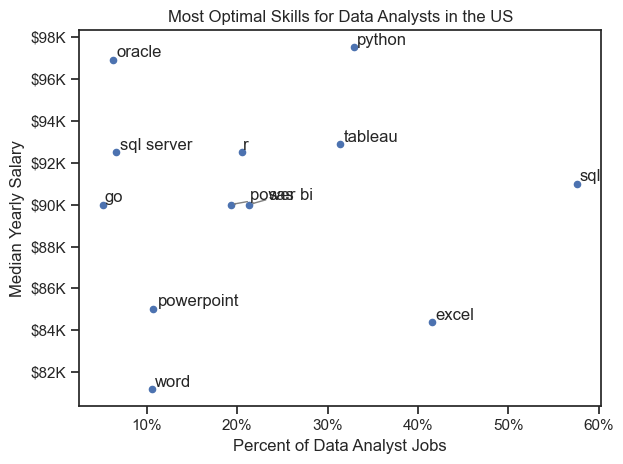

In [23]:
from adjustText import adjust_text

df_DA_skills_high_demand.plot(kind='scatter', x='skill_percent', y='median_salary')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [24]:
df['job_type_skills'].head(10)

0                                                 None
1    {'analyst_tools': ['power bi', 'tableau'], 'pr...
2    {'analyst_tools': ['dax'], 'cloud': ['azure'],...
3    {'cloud': ['aws'], 'libraries': ['tensorflow',...
4    {'cloud': ['oracle', 'aws'], 'other': ['ansibl...
5    {'cloud': ['gcp'], 'programming': ['python', '...
6    {'cloud': ['gcp', 'bigquery'], 'databases': ['...
7    {'cloud': ['gcp', 'azure', 'aws', 'bigquery', ...
8    {'analyst_tools': ['excel', 'powerpoint', 'pow...
9    {'analyst_tools': ['excel'], 'cloud': ['azure'...
Name: job_type_skills, dtype: object

In [25]:
df_technology = df['job_type_skills'].copy()

# remove duplicates
df_technology = df_technology.drop_duplicates()

# remove NaN values
df_technology = df_technology.dropna()

# combine all dictionaries into one
technology_dict = {}
for row in df_technology:
    row_dict = ast.literal_eval(row) # convert string to dictionary
    for key, value in row_dict.items():
        if key in technology_dict : # if key already exists in technology_dict, add value to existings.
            technology_dict[key] += value
    else:                           # if key does not exist in technology_dict, add key and value
        technology_dict[key] = value

# remove duplicates by converting values to set then back to list
for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))
    
technology_dict

{'programming': ['python', 'perl', 'bash'],
 'analyst_tools': ['powerpoint',
  'excel',
  'sap',
  'word',
  'tableau',
  'splunk',
  'looker',
  'power bi',
  'alteryx'],
 'webframeworks': ['fastapi'],
 'libraries': ['spark',
  'spring',
  'pytorch',
  'react',
  'kafka',
  'hadoop',
  'graphql',
  'tensorflow',
  'gdpr',
  'airflow'],
 'sync': ['slack'],
 'other': ['git',
  'docker',
  'kubernetes',
  'terraform',
  'gitlab',
  'github',
  'atlassian',
  'flow',
  'ansible'],
 'cloud': ['redshift',
  'snowflake',
  'gcp',
  'oracle',
  'azure',
  'bigquery',
  'aws'],
 'databases': ['neo4j',
  'firebase',
  'redis',
  'mongodb',
  'firestore',
  'db2',
  'elasticsearch',
  'cassandra',
  'sqlite',
  'mysql',
  'mariadb',
  'couchbase',
  'dynamodb',
  'postgresql',
  'sql server'],
 'async': ['confluence', 'notion', 'jira', 'trello'],
 'os': ['windows', 'linux', 'unix']}

In [26]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=['technology', 'skills'])

df_technology = df_technology.explode('skills')

df_technology

,technology,skills
0,programming,python
0,programming,perl
0,programming,bash
1,analyst_tools,powerpoint
1,analyst_tools,excel
...,...,...
8,async,jira
8,async,trello
9,os,windows
9,os,linux


In [27]:
df_plot = df_DA_skills_high_demand.merge(df_technology, left_on='job_skills', right_on='skills')

In [30]:
df_plot

,skill_count,median_salary,skill_percent,technology,skills
0,1808,84392.00,41.563218,analyst_tools,excel
1,1431,97500.00,32.896552,programming,python
2,1364,92875.00,31.356322,analyst_tools,tableau
3,838,90000.00,19.264368,analyst_tools,power bi
4,462,85000.00,10.620690,analyst_tools,powerpoint
5,461,81194.75,10.597701,analyst_tools,word
6,286,92500.00,6.574713,databases,sql server
7,274,96923.75,6.298851,cloud,oracle


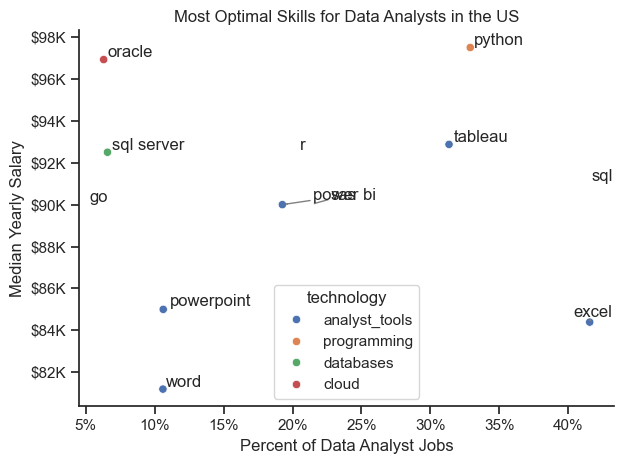

In [32]:
from adjustText import adjust_text

# df_plot.plot(kind='scatter', x='skill_percent', y='median_salary')
sns.scatterplot(
    data=df_plot,
    x='skill_percent',
    y='median_salary',
    hue='technology'
)

sns.despine()
sns.set_theme(style='ticks')

# Prepare texts for adjustText
texts = []
for i, txt in enumerate(df_DA_skills_high_demand.index):
    texts.append(plt.text(df_DA_skills_high_demand['skill_percent'].iloc[i], df_DA_skills_high_demand['median_salary'].iloc[i], txt))

# Adjust text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# Set axis labels, title, and legend
plt.xlabel('Percent of Data Analyst Jobs')
plt.ylabel('Median Yearly Salary')
plt.title('Most Optimal Skills for Data Analysts in the US')

from matplotlib.ticker import PercentFormatter
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()